# Discretization

---

In this notebook, you will deal with continuous state and action spaces by discretizing them. This will enable you to apply reinforcement learning algorithms that are only designed to work with discrete spaces.

### 1. Import the Necessary Packages

In [1]:
import sys
import gym
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

### 2. Specify the Environment, and Explore the State and Action Spaces

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.  Let's use an environment that has a continuous state space, but a discrete action space.


In [2]:
env = gym.make('MountainCar-v0')
env.seed(123)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


[123]

Code to observe a random agent

In [47]:
def random_agent(env):
    state = env.reset()
    score = 0
    
    for i in range(300):
        action = env.action_space.sample()
        env.render()
        state, reward, done, info = env.step(action)
        score += reward
        
        if done:
            break
            
    print(f'Total rewards: {score}.')
    env.close()


random_agent(env)

Total rewards: -200.0.


Explore the observation space and action space

Based on https://en.wikipedia.org/wiki/Mountain_car_problem:
- the observation space is a two-dimensional continuous space:
    - Velocity: [-0.7, 0.7]
    - Position: [-1.2, 0.6]
- the action space is a one-dimensional discrete space:
    - [left, neutral, right]
- the reward:
    - for every time step, the reward is -1
- termination:
    - position >= 0.6

In [4]:
# explore the observation space
print(f'Observation space size: {env.observation_space}')
# dir(env.observation_space)
print(f'- Low: {env.observation_space.low}, {env.observation_space.low.dtype}')
print(f'- High: {env.observation_space.high}, {env.observation_space.high.dtype}')

Observation space size: Box(2,)
- Low: [-1.2  -0.07], float32
- High: [0.6  0.07], float32


In [5]:
# Random sample from observation space
for _ in range(10):
    print(env.observation_space.sample())

[-0.622 -0.039]
[-0.946 -0.056]
[ 0.571 -0.034]
[-0.233 -0.007]
[-1.021 -0.021]
[-0.355  0.048]
[ 0.428 -0.065]
[-0.285 -0.047]
[0.202 0.051]
[-0.459 -0.05 ]


In [6]:
# explore the action space
print(f'Action space size: {env.action_space}')

Action space size: Discrete(3)


### 3. Discretize the State Space with a Uniform Grid

We will discretize the space using a uniformly-spaced grid. Implement the following function to create such a grid, given the lower bounds (`low`), upper bounds (`high`), and number of desired `bins` along each dimension. It should return the split points for each dimension, which will be 1 less than the number of bins.

For instance, if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, and `bins = (10, 10)`, then your function should return the following list of 2 NumPy arrays:

```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Note that the ends of `low` and `high` are **not** included in these split points. It is assumed that any value below the lowest split point maps to index `0` and any value above the highest split point maps to index `n-1`, where `n` is the number of bins along that dimension.

In [7]:
def create_uniform_grid(low, high, bins=(10, 10)):
    result = []
    for low_value, high_value, num_bins in zip(low, high, bins):
        result_bins = []
        grid_size = (high_value - low_value) / num_bins
        
        for i in range(1, num_bins):
            result_bins.append(low_value + grid_size * i)
        
        result.append(np.array(result_bins))
    
    return result


# test
low = [-1.0, -5.0]
high= [1.0, 5.0]
create_uniform_grid(low, high)

[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

In [8]:
# A more elegent solution using `np.linspace`

def create_uniform_grid_linspace(low, high, bins=(10, 10)):
    return [np.linspace(low_value, high_value, num_bins+1)[1:-1] for low_value, high_value, num_bins in zip(low, high, bins)]

# test
low = [-1.0, -5.0]
high= [1.0, 5.0]
create_uniform_grid_linspace(low, high)

[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

Now write a function that can convert samples from a continuous space into its equivalent discretized representation, given a grid like the one you created above. You can use the [`numpy.digitize()`](https://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.digitize.html) function for this purpose.

Assume the grid is a list of NumPy arrays containing the following split points:
```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Here are some potential samples and their corresponding discretized representations:
```
[-1.0 , -5.0] => [0, 0]
[-0.81, -4.1] => [0, 0]
[-0.8 , -4.0] => [1, 1]
[-0.5 ,  0.0] => [2, 5]
[ 0.2 , -1.9] => [6, 3]
[ 0.8 ,  4.0] => [9, 9]
[ 0.81,  4.1] => [9, 9]
[ 1.0 ,  5.0] => [9, 9]
```

**Note**: There may be one-off differences in binning due to floating-point inaccuracies when samples are close to grid boundaries, but that is alright.

In [9]:
import bisect


def discretize(sample, grid):
    # using binary search to find the position for each dimension
    return [bisect.bisect_right(row, elem) for row, elem in zip(grid, sample)]


def discretize_using_digitize(sample, grid):
    # using `numpy.digitize`
    return [np.digitize(elem, bins) for elem, bins in zip(sample, grid)]

# test
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")


Samples:
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]])


### 4. Visualization

It might be helpful to visualize the original and discretized samples to get a sense of how much error you are introducing.


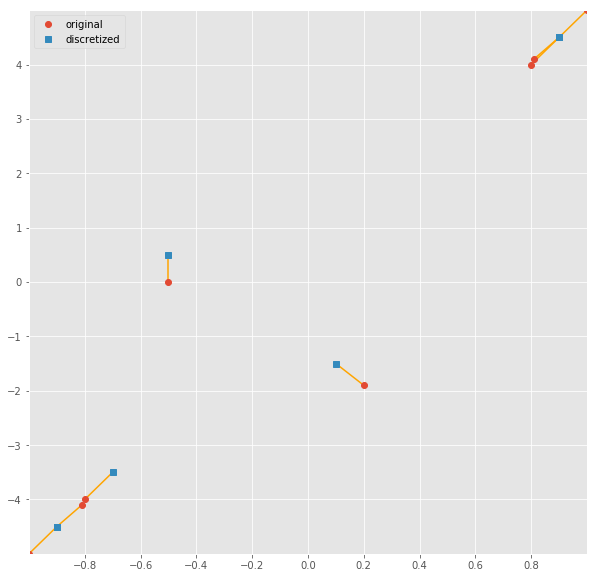

In [10]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples

    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])

    
visualize_samples(samples, discretized_samples, grid, low, high)

Now that we have a way to discretize a state space, let's apply it to our reinforcement learning environment.

In [11]:
# create a grid for observation space
state_grid = create_uniform_grid(
    env.observation_space.low,
    env.observation_space.high,
    bins=(10, 10))

state_grid

[array([-1.02, -0.84, -0.66, -0.48, -0.3 , -0.12,  0.06,  0.24,  0.42]),
 array([-0.056, -0.042, -0.028, -0.014,  0.   ,  0.014,  0.028,  0.042,  0.056])]

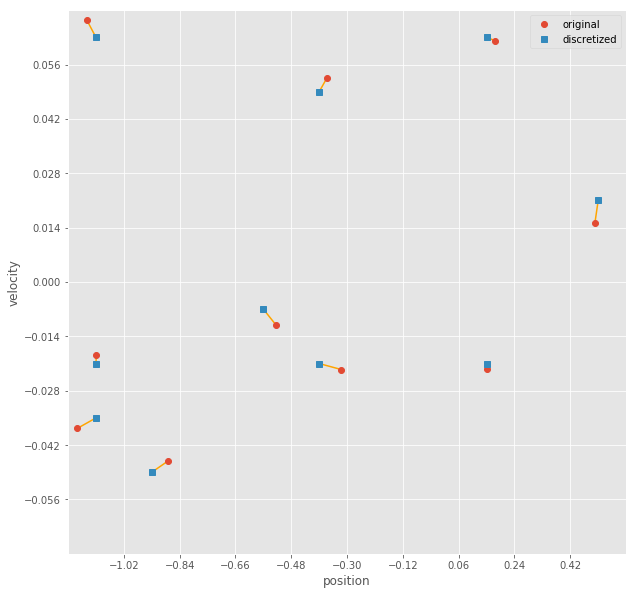

In [12]:
# Obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])
visualize_samples(state_samples, discretized_state_samples, state_grid,
                  env.observation_space.low, env.observation_space.high)
plt.xlabel('position'); plt.ylabel('velocity');  # axis labels for MountainCar-v0 state space

### 5. Q-Learning

In [35]:
import random
from collections import defaultdict


class Agent():
    
    def __init__(self, env, state_grid, alpha=0.01, gamma=1,
                 epsilon_init=1, epsilon_decay=0.995, epsilon_min=-np.inf):
        self._env = env
        self._Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self._state_grid = state_grid

        self._alpha = alpha
        self._gamma = gamma
        self._epsilon = epsilon_init
        self._epsilon_decay = epsilon_decay
        self._epsilon_min = epsilon_min
        
    def test(self):
        state = self._env.reset()
        score = 0

        while True:
            action = self.pick_action(state)
            next_state, reward, done, info = self._env.step(action)
            state = next_state
            score += reward

            if done:
                return score

    def train(self, num_episodes):
        scores = []
        max_ave_score = -np.inf

        for i in range(1, num_episodes+1):
            if len(scores) > 100:
                ave_score = np.mean(scores[-100:])
                max_ave_score = max(max_ave_score, ave_score)

            if i % 100 == 0:
                print(f'\rEpisode {i}/{num_episodes} | Max Average Score: {max_ave_score}', end='')
                sys.stdout.flush()
            
            scores.append(self.run_episode())
            self._epsilon = max(self._epsilon * self._epsilon_decay, self._epsilon_min)
        
        return scores
        
    def run_episode(self):
        score = 0
        state = self._env.reset()
        
        while True:
            action = self.pick_action(state)
            next_state, reward, done, info = self._env.step(action)
            score += reward
            
            if not done:
                self.update_Q(state, action, reward, next_state)
                state = next_state
            else:
                self.update_Q(state, action, reward, None)
                return score
    
    def pick_action(self, state):
        discretized_state = self.discretize(state)
        if random.random() > self._epsilon:
            return np.argmax(self._Q[discretized_state])
        else:
            return random.choice(np.arange(len(self._Q[discretized_state])))

    def update_Q(self, state, action, reward, next_state=None):
        discretized_state = self.discretize(state)
        max_q = 0
        
        if next_state is not None:
            discretized_next_state = self.discretize(next_state)
            max_q = np.max(self._Q[discretized_next_state])
        
        approx_return = reward + self._gamma * max_q
        current_q = self._Q[discretized_state][action]
        self._Q[discretized_state][action] += self._alpha * (approx_return - current_q)
        return

    def discretize(self, state):
        return tuple([bisect.bisect_right(row, elem) for row, elem in zip(self._state_grid, state)])

    
agent = Agent(env, state_grid)

In [36]:
def train_agent(agent, num_episodes=20000):
    scores = agent.train(num_episodes)
    return scores

scores = train_agent(agent)

Episode 20000/20000 | Max Average Score: -133.48

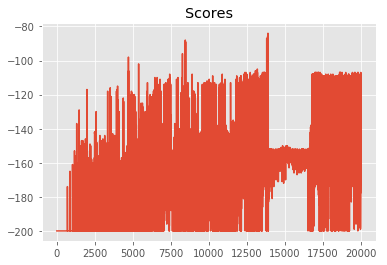

In [37]:
# Plot scores obtained per episode
plt.plot(scores); plt.title("Scores");

If the scores are noisy, it might be difficult to tell whether your agent is actually learning. To find the underlying trend, you may want to plot a rolling mean of the scores. Let's write a convenience function to plot both raw scores as well as a rolling mean.

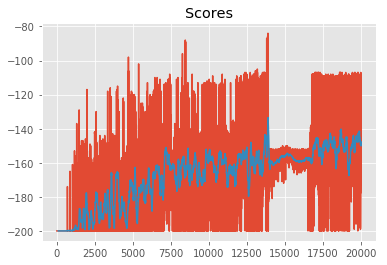

In [38]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

You should observe the mean episode scores go up over time. Next, you can freeze learning and run the agent in test mode to see how well it performs.

Tested 100 episodes with average score = -139.96


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9    -136.4
10   -136.8
11   -138.7
12   -137.3
13   -140.8
14   -141.3
15   -141.8
16   -144.5
17   -142.9
18   -140.1
19   -139.8
20   -139.5
21   -138.5
22   -139.1
23   -138.5
24   -139.2
25   -138.6
26   -138.4
27   -138.1
28   -141.0
29   -136.9
      ...  
70   -141.1
71   -140.9
72   -138.3
73   -138.4
74   -138.9
75   -140.9
76   -138.7
77   -133.6
78   -135.4
79   -135.4
80   -136.1
81   -138.1
82   -143.1
83   -142.4
84   -138.0
85   -133.5
86   -133.5
87   -138.5
88   -136.8
89   -140.4
90   -138.4
91   -136.3
92   -135.2
93   -135.6
94   -138.3
95   -142.2
96   -144.1
97   -143.1
98   -145.0
99   -146.1
Length: 100, dtype: float64

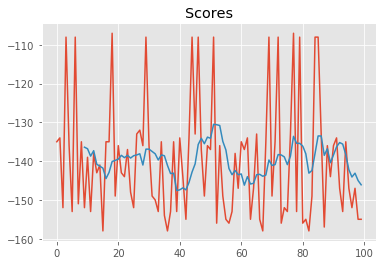

In [39]:
test_scores = [agent.test() for _ in range(100)]
print(f'Tested {len(test_scores)} episodes with average score = {np.mean(test_scores)}')
plot_scores(test_scores, rolling_window=10)

### 6. Modify the Grid

Now it's your turn to play with the grid definition and see what gives you optimal results. Your agent's final performance is likely to get better if you use a finer grid, with more bins per dimension, at the cost of higher model complexity (more parameters to learn).

In [42]:
new_state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, (30, 30))
new_agent = Agent(env, new_state_grid)
new_score = train_agent(agent, 50000)
plot_scores(new_score)

Episode 10500/50000 | Max Average Score: -142.51

KeyboardInterrupt: 

Test the new agent

Tested 100 episodes with average score = -200.0


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9    -180.8
10   -180.8
11   -180.8
12   -184.7
13   -179.3
14   -181.9
15   -181.7
16   -190.5
17   -194.4
18   -194.4
19   -185.5
20   -184.3
21   -184.3
22   -184.3
23   -189.7
24   -180.9
25   -181.1
26   -181.1
27   -181.1
28   -177.6
29   -185.3
      ...  
70   -183.3
71   -183.3
72   -182.1
73   -182.1
74   -182.1
75   -184.6
76   -184.6
77   -189.9
78   -189.9
79   -197.3
80   -197.3
81   -197.3
82   -198.5
83   -189.6
84   -189.6
85   -188.4
86   -188.4
87   -184.8
88   -184.8
89   -186.3
90   -186.3
91   -177.4
92   -172.6
93   -181.0
94   -181.0
95   -182.2
96   -182.2
97   -185.8
98   -185.8
99   -185.8
Length: 100, dtype: float64

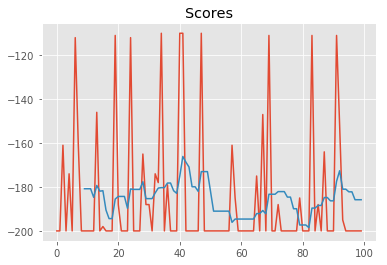

In [34]:
new_test_scores = [new_agent.test() for _ in range(100)]
print(f'Tested {len(new_test_scores)} episodes with average score = {np.mean(new_test_scores)}')
plot_scores(test_scores, rolling_window=10)

### 7. Watch a Smart Agent

In [50]:
state = agent._env.reset()
score = 0

for _ in range(200):
    action = agent.pick_action(state)
    agent._env.render()
    next_state, reward, done, info = agent._env.step(action)
    state = next_state
    score += reward

    if done:
        break

print(score)
agent._env.close()

-135.0
